<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/kang/rnnNameUnit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
print(findFiles('gdrive/My Drive/data/data/names/*.txt'))


['gdrive/My Drive/data/data/names/Arabic.txt', 'gdrive/My Drive/data/data/names/English.txt', 'gdrive/My Drive/data/data/names/Chinese.txt', 'gdrive/My Drive/data/data/names/French.txt', 'gdrive/My Drive/data/data/names/Dutch.txt', 'gdrive/My Drive/data/data/names/Czech.txt', 'gdrive/My Drive/data/data/names/Italian.txt', 'gdrive/My Drive/data/data/names/Greek.txt', 'gdrive/My Drive/data/data/names/Irish.txt', 'gdrive/My Drive/data/data/names/German.txt', 'gdrive/My Drive/data/data/names/Japanese.txt', 'gdrive/My Drive/data/data/names/Korean.txt', 'gdrive/My Drive/data/data/names/Polish.txt', 'gdrive/My Drive/data/data/names/Portuguese.txt', 'gdrive/My Drive/data/data/names/Vietnamese.txt', 'gdrive/My Drive/data/data/names/Russian.txt', 'gdrive/My Drive/data/data/names/Spanish.txt', 'gdrive/My Drive/data/data/names/Scottish.txt']


In [18]:
#데이터 준비
import unicodedata
import string

all_letters = string.ascii_letters + " .,;''"
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
  )


category_lines = {}
all_categories = []

#파일을 읽고 줄 단위로 분리
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('gdrive/My Drive/data/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines
  
n_categories = len(all_categories)
print(n_categories)
print(category_lines['Italian'][:5])

18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [22]:
#Tensor로 변경

import torch

# all_letters로 문자 인덱스 찾기
def letterToIndex(letter):
  return all_letters.find(letter)

#<1*n_letters> Tensor로 변환
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# <line_length * 1 * n_letters> (one-hot벡터의 array로 변경)
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])
torch.Size([5, 1, 58])


In [47]:
#RNN 수행

import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, inputSize, hiddenSize, outputSize):
    super(RNN, self).__init__()
    
    self.hiddenSize = hiddenSize
    
    self.inputToHidden = nn.Linear(inputSize + hiddenSize, hiddenSize)
    self.inputToOutput = nn.Linear(inputSize + hiddenSize, outputSize)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.inputToHidden(combined)
    output = self.inputToOutput(combined)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hiddenSize)
  
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

print('start rn')
output, next_hidden = rnn(input, hidden)
print(output)

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

RNN(
  (inputToHidden): Linear(in_features=186, out_features=128, bias=True)
  (inputToOutput): Linear(in_features=186, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
start rn
tensor([[-2.8704, -2.9595, -2.9635, -3.0341, -3.0048, -2.8132, -2.8163, -2.9142,
         -2.9404, -2.7916, -2.9140, -2.7931, -2.8894, -2.8263, -2.8567, -2.8303,
         -2.9957, -2.8623]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.8704, -2.9595, -2.9635, -3.0341, -3.0048, -2.8132, -2.8163, -2.9142,
         -2.9404, -2.7916, -2.9140, -2.7931, -2.8894, -2.8263, -2.8567, -2.8303,
         -2.9957, -2.8623]], grad_fn=<LogSoftmaxBackward>)


In [48]:
#학습

print(output)
#가장 확률이 높은 카테고리 이름과 번호 반환
def categoryFromOutput(output):
  top_n, top_i = output.topk(1) #tensor의 가장 큰 값 및 주소
  category_i = top_i[0].item() # tensor에서 정수 값으로 변경
  return all_categories[category_i], category_i

print(categoryFromOutput(output))


#랜덤으로 학습예시를 빠르게 얻기
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category = ', category, '/ line = ', line)

tensor([[-2.8704, -2.9595, -2.9635, -3.0341, -3.0048, -2.8132, -2.8163, -2.9142,
         -2.9404, -2.7916, -2.9140, -2.7931, -2.8894, -2.8263, -2.8567, -2.8303,
         -2.9957, -2.8623]], grad_fn=<LogSoftmaxBackward>)
('German', 9)
category =  French / line =  Poirier
category =  Irish / line =  O'Boyle
category =  German / line =  Wang
category =  Russian / line =  Vaistuh
category =  Czech / line =  Fillipova
category =  Russian / line =  Billevich
category =  Russian / line =  Zholtovsky
category =  Portuguese / line =  Ferreira
category =  Spanish / line =  Santos
category =  Greek / line =  Kaloxylos


In [0]:
#네트워크 학습
#RNN의 마지막 계층이 nn.LogSoftmax니까 손실함수로는 nn.NLLLoss가 적합하다고 한다.

criterion = nn.NLLLoss()

#1. input, output Tensor 생성
#2. 0으로 초기화 된 hidden 생성
#3. 각 문자를 읽고, 다음 문자를 위한 hidden 상태 유지
#4. 목표와 최종 출력 비교
#5. backward
#6. 출력과 loss 반환

learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()
  
  rnn.zero_grad()
  
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
    
  loss = criterion(output, category_tensor)
  loss.backward()
  
  for p in rnn.parameters():
    p.data.add_(-learning_rate, p.grad.data)
    
  return output, loss.item()

In [50]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m * 60
  return '%dm %ds' %(m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss
  
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = 'check' if guess == category else 'false (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/ n_iters*100,
                       timeSince(start), loss, line, guess, correct))
    
    if iter % plot_every == 0:
      all_losses.append(current_loss/ plot_every)
      current_loss = 0

5000 5% (0m 5s) 3.1887 Theohari / Spanish false (Greek)
10000 10% (0m 11s) 2.3540 Jordan / Scottish false (Polish)
15000 15% (0m 17s) 2.9365 Wojda / Spanish false (Polish)
20000 20% (0m 23s) 1.7276 Stoep / Dutch check
25000 25% (0m 28s) 0.7501 Araujo / Portuguese check
30000 30% (0m 34s) 0.5299 Otsuka / Japanese check
35000 35% (0m 40s) 1.1122 Shi / Korean false (Chinese)
40000 40% (0m 46s) 1.1910 Kreskas / Greek check
45000 45% (0m 51s) 0.5560 Sinclair / Scottish check
50000 50% (0m 57s) 0.8997 Ramires / Portuguese check
55000 55% (1m 3s) 1.8106 Neskrebin / German false (Russian)
60000 60% (1m 9s) 0.8566 Kuffel / Czech check
65000 65% (1m 15s) 3.9746 Bartosz / Spanish false (Polish)
70000 70% (1m 21s) 1.6664 Pae / Vietnamese false (Korean)
75000 75% (1m 26s) 6.4163 Altshuler / German false (Russian)
80000 80% (1m 32s) 1.4351 Rodwell / Scottish false (English)
85000 85% (1m 38s) 0.1269 Byon / Korean check
90000 90% (1m 44s) 1.6853 Tadhg / Arabic false (Irish)
95000 95% (1m 49s) 1.7321 

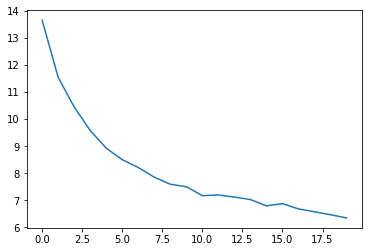

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

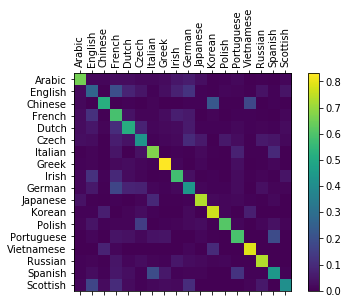

In [55]:
# 다른 카테고리에서 잘 작동하는지 확인하기 위해 실제 행이 네트워크에서 어떤 언어로
# 추측 되는 지를 확인 하기 위한 confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 라인의 출력
def evaluate(line_tensor):
  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

#예시들 중에서 어떤 것이 정확한지를 기록
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1
  
#정규화
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()
  
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_categories, rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()